<a href="https://colab.research.google.com/github/heesukjang/W207_AppliedML_Fall2022/blob/main/W207_Breast_Cancer_IDC_Prediction_Using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## FALL 2022<br>
**Heesuk Jang**
 

#Predicting IDC (Invasive Ductal Carcinoma 침윤성 유관암) with Breast Histopathology (조직병리학) Images using a CNN

In [1]:
import pandas as pd
import numpy as np
import os
import re
import random
import joblib
import glob

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.patches as patches

from sklearn.utils import shuffle
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from scipy import stats
from collections import Counter
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *                            # confusion_matrix, log_loss, accuracy_score
from sklearn.model_selection import *                    # train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing
from sklearn.preprocessing import *
from sklearn.ensemble import *
from sklearn.svm import *
from sklearn.linear_model import *                       # LinearRegression
from sklearn.discriminant_analysis import *
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.plotting import plot_decision_regions

import tensorflow as tf
from keras import metrics
from tensorflow.keras import initializers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import RandomFlip
from tensorflow.keras.layers import RandomZoom
from tensorflow.keras.layers import RandomRotation
# from tensorflow.keras.layers import Conv2D
# from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
tf.get_logger().setLevel('INFO')

import cv2 as cv
import skimage.io as io

import warnings
warnings.filterwarnings('ignore')

# Required to read the data from Kaggle
from google.colab import drive
drive.mount('/content/gdrive')
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle"

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

Mounted at /content/gdrive


In [2]:
%pwd

'/content'

## Load data as a zip file directly from [Kaggle](https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images) to Colab

In [8]:
!kaggle datasets download -d paultimothymooney/breast-histopathology-images

100% 3.10G/3.10G [00:23<00:00, 190MB/s]
100% 3.10G/3.10G [00:23<00:00, 144MB/s]


## Unzip the downloaded zip and remove the original zip file

In [10]:
# !unzip \*.zip && rm *.zip

In [11]:
%ls

10253/  10305/  12881/  13018/  14153/  16085/  8980/  9255/
10254/  10306/  12882/  13019/  14154/  16165/  8984/  9256/
10255/  10307/  12883/  13020/  14155/  16166/  9022/  9257/
10256/  10308/  12884/  13021/  14156/  16167/  9023/  9258/
10257/  12241/  12886/  13022/  14157/  16531/  9029/  9259/
10258/  12242/  12890/  13023/  14188/  16532/  9035/  9260/
10259/  12626/  12891/  13024/  14189/  16533/  9036/  9261/
10260/  12748/  12892/  13025/  14190/  16534/  9037/  9262/
10261/  12749/  12893/  13106/  14191/  16550/  9041/  9265/
10262/  12750/  12894/  13400/  14192/  16551/  9043/  9266/
10264/  12751/  12895/  13401/  14209/  16552/  9044/  9267/
10268/  12752/  12896/  13402/  14210/  16553/  9073/  9290/
10269/  12810/  12897/  13403/  14211/  16554/  9075/  9291/
10272/  12811/  12898/  13404/  14212/  16555/  9076/  9319/
10273/  12817/  12900/  13458/  14213/  16568/  9077/  9320/
10274/  12818/  12901/  13459/  14304/  16569/  9078/  9321/
10275/  12819/  12905/  

In [6]:
# main_fol = '/Users/heesukjang/Desktop/W207_Fall2022_AppliedML/Final_Project_BreastCancerClassification/data/archive/IDC_regular_ps50_idx5/'
# idc_folder = os.path.join(main_fol + '*/1/')
# non_idc_folder = os.path.join(main_fol + '*/0/')

# idc_images = glob.glob(idc_folder + '*.png')
# idc_list = [x for x in idc_images]
# print(idc_list)

## Read image files from **IDC_regular_ps50_idx5**

In [12]:
def read_image_files(binary_class):
  current_working_dir = os.getcwd()
  folder = 'IDC_regular_ps50_idx5/*/'

  image_files_w_path, image_files_wo_path = [], []
  for img in glob.glob(os.path.join(current_working_dir, folder + binary_class + '/') + '*.png'):
    image_files_w_path.append(img)
    image_wo_path = os.path.basename(img)
    image_files_wo_path.append(image_wo_path)    
  return image_files_wo_path, image_files_w_path

class_1_malignant_wo_path, class_1_malignant_w_path = read_image_files('1')
class_0_benign_wo_path, class_0_benign_w_path = read_image_files('0')
full_data_wo_path = class_1_malignant_wo_path + class_0_benign_wo_path
full_data_w_path = class_1_malignant_w_path + class_0_benign_w_path

print('class_1:\n',class_1_malignant_wo_path[:2])
print('\nclass_0:\n',class_0_benign_wo_path[:2])
print('\nclass_1 and class_0 combined:\n',full_data_wo_path[0], ',', full_data_wo_path[-1])
print('\nclass_1 with full path:\n',class_1_malignant_w_path[:2])

class_1:
 ['9075_idx5_x1201_y251_class1.png', '9075_idx5_x851_y101_class1.png']

class_0:
 ['9075_idx5_x1101_y1101_class0.png', '9075_idx5_x1001_y2151_class0.png']

class_1 and class_0 combined:
 9075_idx5_x1201_y251_class1.png , 13018_idx5_x2251_y351_class0.png

class_1 with full path:
 ['/content/IDC_regular_ps50_idx5/9075/1/9075_idx5_x1201_y251_class1.png', '/content/IDC_regular_ps50_idx5/9075/1/9075_idx5_x851_y101_class1.png']


## Check the number of image files in each class


In [13]:
def check_class_size(class_1, class_0):
  class_1_size, class_0_size = len(class_1), len(class_0)
  count = pd.Series([class_1_size, class_0_size])
  percent = round(count/(class_1_size + class_0_size)*100, 2)
  df_perc = pd.concat({'class_count':count, 'class_percent(%)':percent}, axis=1)
  df_perc['class'] = ['Class 1 (Malignant)', 'Class 0 (Benign)']
  df_perc = df_perc[['class','class_count','class_percent(%)']]
  print('Total Count = ', class_1_size + class_0_size)
  return df_perc

check_class_size(class_1_malignant_wo_path, class_0_benign_wo_path)

Total Count =  277524


,class,class_count,class_percent(%)
0,Class 1 (Malignant),78786,28.39
1,Class 0 (Benign),198738,71.61


## Create dataframes for each class

In [14]:
def create_class_df(): 
  image_list_w_path = [x for x in class_1_malignant_w_path]
  image_list_w_path.extend([x for x in class_0_benign_w_path])
  df_idc= pd.DataFrame(np.concatenate([['IDC']*len(class_1_malignant_w_path), ['Non_IDC']*len(class_0_benign_w_path)]), columns=['class'])
  df_idc['image'] = [x for x in image_list_w_path]
  print('Shape: ', df_idc.shape)
  return df_idc

df_full = create_class_df()
df_full

Shape:  (277524, 2)


,class,image
0,IDC,/content/IDC_regular_ps50_idx5/9075/1/9075_idx...
1,IDC,/content/IDC_regular_ps50_idx5/9075/1/9075_idx...
2,IDC,/content/IDC_regular_ps50_idx5/9075/1/9075_idx...
3,IDC,/content/IDC_regular_ps50_idx5/9075/1/9075_idx...
4,IDC,/content/IDC_regular_ps50_idx5/9075/1/9075_idx...
...,...,...
277519,Non_IDC,/content/IDC_regular_ps50_idx5/13018/0/13018_i...
277520,Non_IDC,/content/IDC_regular_ps50_idx5/13018/0/13018_i...
277521,Non_IDC,/content/IDC_regular_ps50_idx5/13018/0/13018_i...
277522,Non_IDC,/content/IDC_regular_ps50_idx5/13018/0/13018_i...


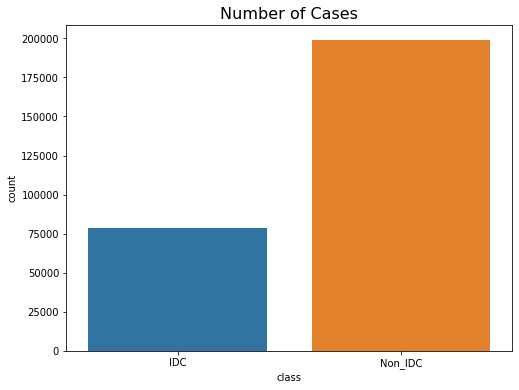

In [15]:
plt.figure(figsize=(8,6))
plt.title('Number of Cases', fontsize=16)
sns.countplot(df_full['class'], data=df_full)
plt.show()

# 1. Binary Classification 
: IDC vs Non-IDC



## Display 6 images for each class
: 512 (width) by 512 (height) array of pixel values per image

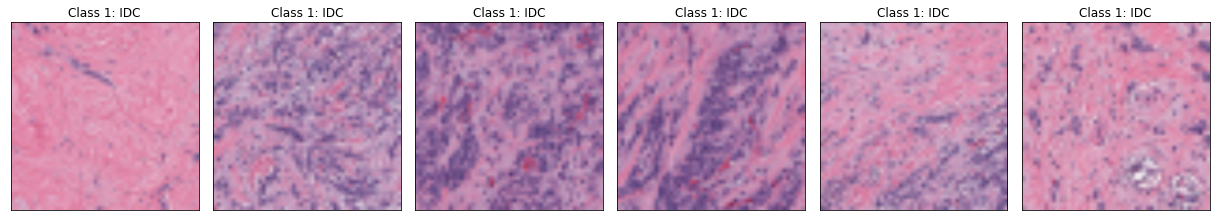

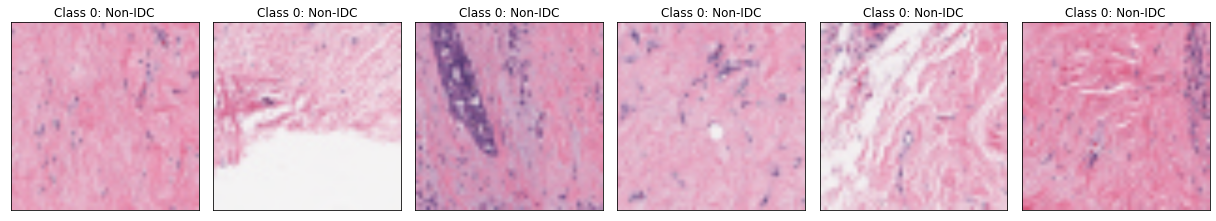

In [30]:
def display_images(subclass, class_name):
  fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(17,6))
  # images = []
  for idx, ax in enumerate(axes.flat):
    img = io.imread(subclass[idx])
    img = cv.resize(img, (512,512))    # resize an image from 50 by 50 to 512 by 512
    ax.imshow(img)
    ax.set_title(class_name)
    ax.set_xticks([])       # remove xticks passing an empty array
    ax.set_yticks([])       # remove yticks passing an empty array
  fig.tight_layout() 
  plt.show() 

display_images(class_1_malignant_w_path, 'Class 1: IDC')
display_images(class_0_benign_w_path, 'Class 0: Non-IDC')

## Store actual images as a vector

In [66]:
# read and store actual images (not the image paths) into the respective variable as a single vector then pass these to the model below
# image_pixels_class1 = [io.imread(img) for img in class_1_malignant_w_path]
# image_pixels_class0 = [io.imread(img) for img in class_0_benign_w_path]
# image_pixels_class0
print('number of class 1 images = ', len(image_pixels_class1))
print('number of class 0 images = ', len(image_pixels_class0))
print('total number of images = ', len(image_pixels_class1 + image_pixels_class0))

number of class 1 images =  78786
number of class 0 images =  198738
total number of images =  277524


In [62]:
full_image_pixels = image_pixels_class1 + image_pixels_class0
print('total number of images = ', len(full_image_pixels), '\n', full_image_pixels[0])

total number of images =  277524 
 [[[221 129 165]
  [221 156 183]
  [216 131 165]
  ...
  [220 144 176]
  [227 159 188]
  [220 152 183]]

 [[199 127 159]
  [222 148 183]
  [224 144 178]
  ...
  [227 155 184]
  [225 151 182]
  [210 136 174]]

 [[213 164 197]
  [216 152 179]
  [219 148 179]
  ...
  [219 145 177]
  [229 142 173]
  [231 162 192]]

 ...

 [[217 142 175]
  [213 175 197]
  [214 162 190]
  ...
  [227 138 169]
  [221 146 178]
  [220 147 180]]

 [[214 157 186]
  [220 147 182]
  [210 159 189]
  ...
  [217 139 171]
  [201 136 172]
  [227 142 173]]

 [[219 150 182]
  [220 150 183]
  [217 165 192]
  ...
  [215 148 182]
  [220 140 174]
  [224 133 165]]]


## Randomize images 


In [60]:
#  randomize image data
# (X_train_digits, Y_train_digits), (X_test_digits, Y_test_digits) = full_image_pixels
train, test = train_test_split(full_image_pixels, test_size=0.2, random_state=42)
print('BEFORE:\n', 'Length: ', len(train), '=> Dim: ', train[0].shape, '\n', train[0])
# print('AFTER:\n', 'Length: ', len(train), '=> Dim: ', train[0].shape, '\n', train[0])

# pd.DataFrame(df_train.iloc[:, :m_train]).drop('finacial_weight', axis=1) # all rows and columns
# y_train = pd.DataFrame(df_train.iloc[:, -1]) # all rows and the last column
# X_test = df_test.drop('finacial_weight', axis=1)
# X_full = [X_train, X_test]

# # TODO
# features = X_train.columns
# print('features:\n',features)
# print(X_train_img.shape)



# def shuffle_data(df):
#   indexes = np.arange(df.shape[0])
#   print('indexes:', indexes)

#   np.random.seed(0)    # get the same results each time    ??????
#   shuffled_indexes = np.random.permutation(indexes)
#   print('shuffled indexes:', shuffled_indexes, '\n')

#   # change the ordering of the original df_features using .reindex()
#   df = df_full.reindex(shuffled_indexes)
#   return df
# full_image_pixels = shuffle_data(full_image_pixels)
# display(full_image_pixels)

BEFORE:
 Length:  222019 => Dim:  (50, 50, 3) 
 [[[228 209 221]
  [247 241 243]
  [244 237 244]
  ...
  [213 133 169]
  [219 140 173]
  [225 178 205]]

 [[242 235 241]
  [223 198 215]
  [247 241 241]
  ...
  [220 156 182]
  [217 145 176]
  [216 148 181]]

 [[244 240 244]
  [243 235 240]
  [219 188 210]
  ...
  [238 218 228]
  [232 200 219]
  [219 161 189]]

 ...

 [[221 163 191]
  [228 189 212]
  [216 159 191]
  ...
  [217 163 198]
  [212 151 183]
  [228 185 205]]

 [[215 140 177]
  [220 152 186]
  [219 155 187]
  ...
  [214 145 176]
  [221 170 198]
  [210 156 189]]

 [[210 135 172]
  [210 134 173]
  [226 174 201]
  ...
  [209 138 177]
  [215 154 186]
  [214 150 184]]]


In [32]:
# #  randomize image data
# def shuffle_data(df):
#   indexes = np.arange(df.shape[0])
#   print('indexes:', indexes)

#   np.random.seed(0)    # get the same results each time    ??????
#   shuffled_indexes = np.random.permutation(indexes)
#   print('shuffled indexes:', shuffled_indexes, '\n')

#   # change the ordering of the original df_features using .reindex()
#   df = df_full.reindex(shuffled_indexes)
#   return df
# full_image_pixels = shuffle_data(full_image_pixels)
# display(full_image_pixels)

## Train/Test Split & Feature Selection

In [26]:
def data_split_and_feature_selection(df, feat_idx):
  split_boundary = int(df.shape[0]*.8)
  train = pd.DataFrame(df.iloc[:split_boundary, feat_idx:])
  test = pd.DataFrame(df.iloc[split_boundary:, feat_idx:])
  return train, test

train, test = data_split_and_feature_selection(df_full, 0)
# print()
# train_vector = np.reshape(train, (67500,))

print('Train Shape: ', train.shape, '\n', train.head(3))
print('\nTest Shape: ', test.shape, '\n', test.head(3))

Train Shape:  (222019, 2) 
           class                                              image
106139  Non_IDC  /content/IDC_regular_ps50_idx5/12911/0/12911_i...
3019        IDC  /content/IDC_regular_ps50_idx5/12752/1/12752_i...
55132       IDC  /content/IDC_regular_ps50_idx5/9250/1/9250_idx...

Test Shape:  (55505, 2) 
           class                                              image
201175  Non_IDC  /content/IDC_regular_ps50_idx5/12908/0/12908_i...
54014       IDC  /content/IDC_regular_ps50_idx5/8974/1/8974_idx...
84344   Non_IDC  /content/IDC_regular_ps50_idx5/9225/0/9225_idx...


## Set 20% of validation data out of training dataset
We don't want to just optimize our model and its hyperparameters for just these train and test data sets. There is a chance that the model will perform badly on unseen data because it hasn't really had the chance to test itself against one. 

To mitigate this, we'll take 20% of our training data and put it into validation data. We'll be optimizing our model on these two before introducing it to our test dataset.

In [19]:
'''
set random_state for repeatability and stratify to make the function understand 
that the portion we split from original df must contain the same proportion of elements as in the original df. 
i.e. suppose for every 10 observations you have 7 IDC and 3 non-IDC in the training dataset. we want the same proportion in the validataion as well.
'''
train_df, val_df = train_test_split(train, test_size=0.2, random_state=13, stratify=train['class'])

In [20]:
print(val_df.shape)
val_df

(44404, 2)


,class,image
78531,IDC,/content/IDC_regular_ps50_idx5/12810/1/12810_i...
67951,IDC,/content/IDC_regular_ps50_idx5/9344/1/9344_idx...
219990,Non_IDC,/content/IDC_regular_ps50_idx5/16165/0/16165_i...
135073,Non_IDC,/content/IDC_regular_ps50_idx5/9126/0/9126_idx...
211291,Non_IDC,/content/IDC_regular_ps50_idx5/9173/0/9173_idx...
...,...,...
192704,Non_IDC,/content/IDC_regular_ps50_idx5/9077/0/9077_idx...
215192,Non_IDC,/content/IDC_regular_ps50_idx5/12930/0/12930_i...
183559,Non_IDC,/content/IDC_regular_ps50_idx5/9123/0/9123_idx...
133401,Non_IDC,/content/IDC_regular_ps50_idx5/9320/0/9320_idx...


## Preprocessing (Normalization)
Normalization helps our algorithm train better. The reason why we typically want normalized pixel values is becasue **neural networks rely on gradient calculations.** These networks are trying to learn how important or how weighty a certain pixel should be in determining the class of an image. Normalizing pixel values help these gradient calculations stay consistent and not get so large that they slow don or prevent network from training. In a typical grayscale image, the pixel values will range from 0-255. we will be using **ImageDataGenerator** to preprocess our data.

In [24]:
# ImageDataGenerator allows the users to perform image augmentation but here we will repurpose it to just normalize our images
# Rescale all the pixel valuesin our images to a value in the range of 0 to 1.
from keras.preprocessing.image import ImageDataGenerator

train_norm = ImageDataGenerator(rescale=1/255)
val_norm = ImageDataGenerator(rescale=1/255)

# train_norm_vector = np.reshape(train_norm, (67500,))

ValueError: ignored

## Feed nomalized train, validataion, and test images to CNN
We need a way to read and then feed to our CNN all those rescaled images from our dataframes and that is where the method flow_from_dataframe comes in.
- **targt_size=(150,150):** can increase or decrease this according to your computational resources.
- **batch_size:** defines the number of samples that we've propagated through the network, basically, number of images per batch that is fed into the CNN. This value typically ranges from 16 - 512. Large batch sizes require more computational power so we here have set this to 32.


In [ ]:
def generate_input_images_to_feed_cnn(df_norm, df, binary):
  '''flow_from_dataframe() generates batches of input iamges that can be used as the input to our network'''  
  generator = df_norm.flow_from_dataframe(
      df,
      x_col='image',
      y_col='class',
      targt_size=(150,150),   # larger images increasing training time with no substantial benefit so resize to smaller scale
      batch_size=32,
      class_mode='binary',    # two classes (IDC vs Non-IDC)
      shuffle=binary,
      seed=7
  )
  return generator

train_generator = generate_input_images_to_feed_cnn(train_norm, train_df, 'True')
val_generator = generate_input_images_to_feed_cnn(val_norm, val_df, 'True')

# shuffle to False on the test_generator since we don't want ImageDataGenerator to be shuffling the test,which it does so by default
test_generator = generate_input_images_to_feed_cnn(val_norm, test, 'False') 

train_generator

## Feature Extraction
The layout of a CNN can be broadly divided into feature extraction and classification.
- **Convolutions:**<br>
    1) Input image<br>
    2) Filter<br>
    3) Feature maps<br>
- **Activation:**<br>
    1) Sigmoid<br>
    2) Tanh<br>
    3) ReLU<br>
    2) Leaky ReLU<br>
- **Pooling:**<br>
    1) Max pooling<br>

## Classification
For classification, the output of the previous layer, that is, the last layer in **feature extraction** becomes the input to what is called the **fully connected layer**. The fully connected layer outputs an undimensional vector where N is the **number of classes**. For example, in a cat or dog problem, N=2. And in a digit classification where the network is supposed to say which digit it is from 0 to 9, N=10. Each number of the N-dimensional vector contains the probability of that particular class, and the class with the highest probability is chosen.

## Model Architecture
Every one of the following parameters can be changed and experimented with to see how it affects the network and its performance, and these things are called **hyperparameters**.
- **filters:** the number of filters we want. let's start with 16
- **kernel_size:** = filter size. A filter is also called **kernel**. Set it to (3,3) = (width, height)
- **activation:** will go with **ReLu**
- **input_shape:** the input dimensions of the image. This will be the same as what we told the ImageDataGenerator. We also have a **depth of 3** since these are color images. The input_shape param is only needed in the 1st convolutional layer.

**Conv2D = 2D convolution layer**. This layer creates a convolution kernel (= filter) that is convolved with the layer input to produce a tensor of outputs. The **number of layers** in a CNN also affects the network performance and is something that'll need to be played around with. For preparing data to be fed into a **fully connected layer**, we need to **flatten** the dataset. And then we'll pass the info to a fully connected layer. We'll be using two fully connected layers here. **Dense** indicates that it is indeed a fully connected layer.

For the **1st Dense layer**, we specify the **number of units or neurons**. Since this is a binary classification problem, we will have 1 neuron or 1 unit for the **final Dense layer**. If it was a **multi-class classification** problem, you will have as many units as there are classes. For the activation function, we will use **Sigmoid**, which we input the value of the last layer and we get a value in the range of 0 to 1. If the value is greater than the threshold value let's say 0.5, we consider the model output as one class or the other class of the value is less than the threshold value.  

Now we created the first CNN network! Now we need to **compile** it. This is where we specify the **configurations of the training process**. First we need to specify a **loss function**. The objective of the model will be **to minimize the loss function**. Since this is a binary classification problem, we will use **binary_crossentropy**. Then we'll specify what type of optimizer the model uses to do this. Optimizers are algorithms or methods, used to change the attributes of a neural network such as **weights and learning rate** in order **to reduce the losses**. They are many types of optimizers. We'll use the **adam optimizer**, which is arguably the most popular. Finally we'll also provide a **metric** for us to see how well the model is doing. Since this is a classification problem, **accuracy** whould work well. To get an overview of the model and the number of params that are in play, you can use **model.summary**.

## Build the first CNN model - Feature Extraction

In [ ]:
# Importing the necessary packages
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.models import Sequential

In [ ]:
def build_model():
  # Building the CNN
  model = Sequential()      # initialize the model using Sequential(), which indicates our network will be stacked with different layers

  # Add the convolutional layers
  model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(150,150,3)))  # 1st convolutional layer
  model.add(MaxPooling2D(pool_size=(2,2)))                                                   # 1st Pooling
  model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))                           # 2nd convolutional layer
  model.add(MaxPooling2D(pool_size=(2,2)))                                                   # 2nd Pooling
  model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))                           # 3rd convolutional layer
  model.add(MaxPooling2D(pool_size=(2,2)))                                                   # 3rd Pooling

  # Flatten the dataset to feed into a fully connected layer
  model.add(Flatten())    # may not need it since I flatten the data prior

  # Fully connected layer
  model.add(Dense(64, activation='relu'))    # For the first layer: 64 = the number of units or neurons
  model.add(Dense(1, activation='sigmoid'))  # For the final layer

  # optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)   # Use the SGD optimizer 

  #  Compiling
  model.compile(loss='binary_crossentropy',
                optimizer='adam',                    # use SGD instead?: optimizer=optimizer
                metrics=['accuracy'])            # metrics=[metrics.binary_accuracy])
  return model

In [ ]:
model = build_model()
model.summary()

In [ ]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=False,
    show_layer_activations=True,
)

## Training the Model

In [ ]:
# There are many other args other th
# an the followin three that you can include here but right now, we're trying to build a minimum viable network.
# from tensorflow import keras
model_1 = model.fit(train_generator, epochs=10, validation_data=val_generator)     # Hyperparam which we can play around: one epoch includes the forward propagation and back propagation

model_1 = pd.DataFrame(model_1.history)
display(model_1)

In [ ]:
plt.figure(figsize=(12,8))

# Plot the loss function for training and validation datasets
plt.subplot(2,2,1)
plt.plot(model_1.history['loss'], label='Training Loss')
plt.plot(model_1.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss - Training vs Validation Dataset')

# Plot the loss function for training and validation datasets
plt.subplot(2,2,2)
plt.plot(model_1.history['accuracy'], label='Training accuracy')
plt.plot(model_1.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.title('Accuracy - Training vs Validation Dataset')

# 2. Prediction 
: predict the most common area that may be detected IDC


## Extract features from file names

In [ ]:
def extract_features(file_list): 
  features = []
  for file in file_list:
    str_feat = re.findall(r'\d+', file)
    int_feat = [int(feat) for feat in str_feat]
    features.append(int_feat)
  df_feat = pd.DataFrame(features, columns=['patient_id', 'd', 'x_coord', 'y_coord', 'class']).drop('d', axis=1)
  df_feat['patch_coord'] = list(zip(df_feat.x_coord, df_feat.y_coord))
  return df_feat[['patient_id','x_coord', 'y_coord', 'patch_coord','class']]

df_features = extract_features(full_data_wo_path)
print(df_features.shape)
display(df_features.head().append(df_features.tail()))

In [ ]:
df_features.info()

## Randomize data 
: As we may use SGD for training, we will randomize sample of the data for each batch so that the gradient computed is representative.

In [ ]:
indexes = np.arange(df_features.shape[0])
print('indexes:', indexes)

np.random.seed(0)    # get the same results each time    ??????
shuffled_indexes = np.random.permutation(indexes)
print('shuffled indexes:', shuffled_indexes, '\n')

# change the ordering of the original df_features using .reindex()
df_features = df_features.reindex(shuffled_indexes)
display(df_features)

## Train/Test split (80/20) & Feature Selection

In [ ]:
split_boundary = int(df_features.shape[0]*.8)

train = pd.DataFrame(df_features.iloc[:split_boundary, 3:])
test = pd.DataFrame(df_features.iloc[split_boundary:, 3:])

print('Train Shape: ', train.shape, '\n', train.head(3))
print('\nTest Shape: ', test.shape, '\n', test.head(3))